# Assignment 5.1 - Prompt Engineering

<h1>Prompting Workflows</h1>
<p>So we where expected to simulate iterative dialouges with an Llm with the goal of "solving a complex financial problem using advanced prompt engineering techniques in Python". This dialogue with the LLM was to be structured in the form of Chain of Thought (CoT) prompting, Self-Consistency Chain of Thought (SC-CoT) prompting, and Few-Shot prompting workflows.</p>
<p>I went ahead and implemented similar LangGraph workflows that lead the Llm interactions through this specific processes.</p>
<p>Referenced: https://langchain-ai.github.io/langgraph/tutorials/workflows/</p>

<h3 style="text-align: center;">Chain-of-Thought / Prompt chaining</h3>

<img
    style="display: block;
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://www.promptingguide.ai/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Fcot.1933d9fe.png&w=1080&q=75"
    alt="1">
</img>

<img
    style="display: block;
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/augmented_llm.png"
    alt="2">
</img>

<p style="text-align: center;">I.e. <i>complex reasoning capabilities through intermediate reasoning steps</i></p>

In [48]:
# model
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:latest", temperature=0.2)

In [49]:
# Schema for structured output

#State definition. couldn't get the pydantic model working...

# class PydanticOutputState(BaseModel):
#    final_amount: float = Field(None, description="The final amount in the investment account.")

from langgraph.graph import MessagesState
# messages + structured output
class State(MessagesState):
    final_amount: float

# Augment the LLM with schema for structured output
#structured_llm = llm.with_structured_output(State)

In [93]:
from langchain_core.messages import HumanMessage
# Node & Tool definition

from typing import List
def final_amount_calculator(annual_returns: List[int], fixed_fee: float, tax_rate: float) -> float:
    """Calculate the final amount in an investment account given annual returnes,
    tax rate on gains, and fixed fees (costs)
    """
    final_amount = sum(annual_returns)*(1-tax_rate)-fixed_fee
    return final_amount

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval."""
    llm_with_tools = llm.bind_tools([final_amount_calculator])
    tool_call = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [tool_call]}

from langgraph.prebuilt import ToolNode
tools = ToolNode([final_amount_calculator])

def generate_response(state: MessagesState):
    """Generate answer. based on the calculated final amount in the investment account."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt (stateless, just the tool call value.
    final_amount = "\n\n".join(answer.content for answer in tool_messages)
    system_message_content = (
        f"You are a Financial Advisor in a fictional world. Provide an explanation to the end user about the final amount in his investment account, which happens to be {final_amount}. Be sure to include a lovely goodbye. Be concise, two paragraphs maximum"
        "\n\n"
    )

    #IGNORE - BEGIN
    not_AI_message = ("\n\n"    "------------------------------------------------------------------------------------------------------"
        f"The calculated final amount in an investments account is {final_amount}."
        "It's me responding since the Llm has guardrails or something that sometimes hinder the final response... LLM BELOW"
    "------------------------------------------------------------------------------------------------------"
    "\n\n")
    #IGNORE - END

    # Run the final generative prompt, with all the context provided.
    response = llm.invoke(system_message_content)
    response.content = (not_AI_message + response.content)
    return {"messages": [response]}

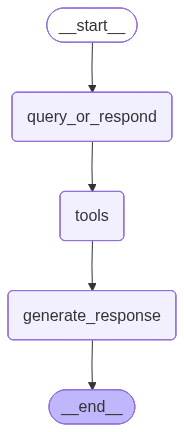

In [94]:
from langgraph.graph import StateGraph, START, END

#we initialize our langgraph
graph = StateGraph(State)
graph.add_node(query_or_respond)
graph.add_node(tools)
graph.add_node(generate_response)

graph.add_edge(START, "query_or_respond")
graph.add_edge("query_or_respond", "tools")
graph.add_edge("tools", "generate_response")
graph.add_edge("generate_response", END)

graph = graph.compile()
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [95]:
prompt = HumanMessage("Hypothetically, how much did I make if I earned [250k, 231k, 50k, 1M, 550k, 67k] in the last couple of years, paying 50k a month on stuff, and tax_rates are at 23%.")
state = graph.invoke({"messages": f"{prompt}"})

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

content='Hypothetically, how much did I make if I earned [250k, 231k, 50k, 1M, 550k, 67k] in the last couple of years, paying 50k a month on stuff, and tax_rates are at 23%.' additional_kwargs={} response_metadata={}
================================== Ai Message ==================================
Tool Calls:
  final_amount_calculator (3e6f5e33-68c9-4dc9-ac1c-404f84f228af)
 Call ID: 3e6f5e33-68c9-4dc9-ac1c-404f84f228af
  Args:
    annual_returns: [250000, 231000, 50000, 1000000, 550000, 67000]
    fixed_fee: 50000
    tax_rate: 0.23
================================= Tool Message =================================
Name: final_amount_calculator

1603960.0
================================== Ai Message ==================================



------------------------------------------------------------------------------------------------------The calculated final amount in an investments account is 1603960.0.It's 

<h3 style="text-align: center;">Self-Consistency Chain of Thought Prompting / Parallelization + Prompt chaining + Evaluator-Optimizer</h3>

<img
    style="display: block;
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/augmented_llm.png"
    alt="1">
</img>

<img
    style="display: block;
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/parallelization.png"
    alt="2">
</img>

<img
    style="display: block;
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/evaluator_optimizer.png"
    alt="3">

<p style="text-align: center;">I.e. <i>sample multiple, diverse reasoning paths through few-shot CoT, and use the generations to select the most consistent answer.</i></p>
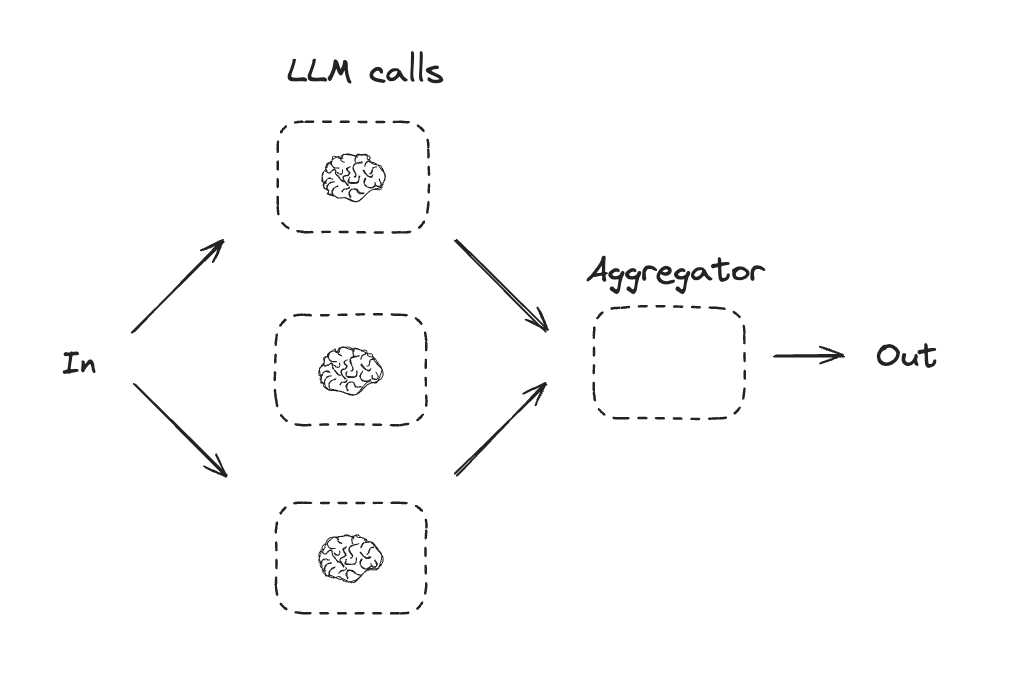

In [407]:
# model
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:latest", temperature=0.2)

In [408]:
from pydantic import Field
from langgraph.graph import MessagesState
from typing import Annotated, List, Literal
import operator

# Schema for structured output
#State definitions...

class Calculator(BaseModel):
    financial_information: list[float] = Field(description="The financial gains recorded, used to make the corresponding financial analysis.")
    tax_rate: float = Field(description="The tax rate that is going to be deducted from the financial gains.")
    fixed_fee: float = Field(description="The annual fixed costs that need to de deducted.")
    method_of_calculation: Literal["Reflection", "Math"] = Field(description="Chosen method to perform the necessary mathematical operations.")
    final_amount: float = Field(description="The calculated final amount in the investment account that must be computed by the LLM..")

# messages + structured output
class FinancialReport(BaseModel):
    calculators: List[Calculator] = Field(description="Group of calculators that all arrive at a calculated final amount.")
    voted_final_amount: float

# Internal states (dynamic)
# Augment the LLM with schema for structured output
planner = llm.with_structured_output(FinancialReport)

In [409]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Send
from typing import List, TypedDict

# Node & Tool definition

class State(MessagesState):
    financial_investments: str # the necessary data inputs
    calculators: list[Calculator] # list of calculators
    completed_calculations: Annotated[
        list, operator.add
    ] # Shared key for the calculators to write to
    voted_final_amount: str # final financial report
    final_financial_report: str

# Worker state
class WorkerState(TypedDict):
    calculator: Calculator
    completed_calculations: Annotated[list, operator.add] # keys must match with other State!

# Nodes / Tools

def orchestrator(state: MessagesState):
    """Orchestrator that spawns multiple different calculators so it can arrive to a correct calculated
        amount in an investment account given the corresponding financial data. The Orchestrator (you) do NOT attempt to make the calculation. Merely spawn the orchestrators.
    """

    # Generate queries...
    calculators = planner.invoke(
        [
            SystemMessage(content="Generate a number of calculators that will attempt to calculate the final amount of money in a financial account given complimentary financial data. You also have to assign the calculation method to each of the spawned calculators. The available calculation methods are either Reflection or Math.  The Orchestrator (you) do NOT attempt to make the calculation. Merely spawn the orchestrators."),
            HumanMessage(content=f"Give each worker the financial data needed: {state["messages"]}."),
        ]
    )

    return {"calculators": calculators.calculators, "financial_investments": state["messages"][-1].content}

def final_amount_calculator(annual_returns: List[int], fixed_fee: float, tax_rate: float) -> float:
    """Calculate the final amount in an investment account given annual returns,
    tax rate on gains, and fixed fees (costs)
    """
    final_amount = sum(annual_returns)*(1-tax_rate)-fixed_fee
    return final_amount

def llm_tool_call(state: MessagesState):
    """Generate tool call for retrieval.
    """

    try:
        print(f"LLM tool call instantiated. Raising the call.")

        # Generate tool call for retrieval. Should write in docstring?
        llm_with_tools = llm.bind_tools([final_amount_calculator])
        calculation = llm_with_tools.invoke(state["messages"])

        # Write the final amount that was calculated.
        return {"messages": [calculation]}

    except Exception as e:
        print(f"Error {e} when raising the tool call.")

from langgraph.prebuilt import ToolNode
tools = ToolNode([final_amount_calculator])

def llm_call(state: WorkerState):
    """Worker uses the available financial_information to calculate the money in the investment account Returns a float number with the answer.
    """

    print(f"LLM call instantiated.")

    calculation = llm.invoke(
        [
            SystemMessage(
                content="Calculate the final amount of money in a financial account given the following financial data."
            ),
            HumanMessage(
                content=f"Here is the available financial data: {state['calculator']}. MANDATORY TO RETURN ONLY the calculated final amount in the account as a FLOAT number. Do the calculations and return the estimated result."
            ),
        ]
    )

    # Write the final amount that was calculated.
    return {"completed_calculations": [calculation.content]}

def quorum(state: State):
    """Comparison of all the provided answers, if one is repeated more than all others it is chosen.
    Else 404 (couldn't arrive to a satisfactory conclusion)...
    """

    final_calculations_stringed = state["completed_calculations"]
    final_calculations = []

    # List of completed GenAI calculations. Didn't really try to find an easier way to do it...
    for calculation in final_calculations_stringed:
        try:
            string_float = float(calculation)
            print(string_float)
        except ValueError:
            # Handle the exception
            string_float = ""
        finally:
            if isinstance(string_float, float):
                final_calculations.append(string_float)

    recent_tool_messages = []

    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt (stateless, just the tool call value.
    final_amount = "\n\n".join(answer.content for answer in tool_messages)

    final_calculations.append(float(final_amount))

    for calculation in final_calculations:
        print("\n\n")
        print("-----------------------------------------------------------------------------------------")
        print(f"{calculation}")
        print("-----------------------------------------------------------------------------------------")
        print("\n\n")

    # searched for a majority counter algorithm...  https://codelucky.com/moores-majority-vote/
    def majority_element(nums):
        # Phase 1: Find candidate
        count = 0
        candidate = None

        for num in nums:
            if count == 0:
                candidate = num
            count += (1 if num == candidate else -1)

        # Phase 2: Verify candidate
        if nums.count(candidate) > len(nums) // 2:
            return candidate
        return None

    winner_calculation = majority_element(final_calculations)

    return {"voted_final_amount": winner_calculation}

# Conditional edge function to create llm_call workers that each make their own calculation
def assign_workers(state: State):
    """Assign a worker to each calculation that must be computed."""

    sends = []

    # Math tool calls will have to be handled separately (trouble running them in parallel)
    for c in state["calculators"]:
        if c.method_of_calculation != "Math":
            sends.append(Send("llm_call", {"calculator": c}))

    return sends


def generate_response(state: State):
    """Generate answer. based on the calculated final amount in the investment account."""

    system_message_content = (
        f"You are a Financial Advisor in a fictional world. Provide an explanation to the end user about the"
        f"final amount in his investment account, which happens to be {state['voted_final_amount']}. Be sure to include a lovely goodbye. Be concise, two paragraphs maximum"
        "\n\n"
    )

    # Run the final generative prompt, with all the context provided.
    response = llm.invoke(system_message_content)
    return {"final_financial_report": response}


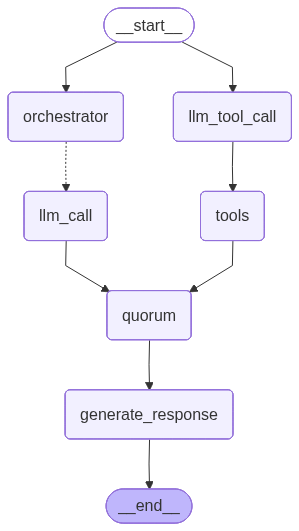

In [410]:
from langgraph.graph import StateGraph, START, END

#we initialize our langgraph

# Build workflow
orchestrator_graph = StateGraph(State)

# Add the nodes
orchestrator_graph.add_node("orchestrator", orchestrator)
orchestrator_graph.add_node("tools", tools)
orchestrator_graph.add_node("llm_tool_call", llm_tool_call)
orchestrator_graph.add_node("llm_call", llm_call)
orchestrator_graph.add_node("quorum", quorum)
orchestrator_graph.add_node("generate_response", generate_response)


# Add edges to connect nodes... #spawned gates change to node
orchestrator_graph.add_edge(START, "orchestrator")
orchestrator_graph.add_edge(START, "llm_tool_call")
orchestrator_graph.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"])
orchestrator_graph.add_edge("llm_call", "quorum")
orchestrator_graph.add_edge("llm_tool_call", "tools")
orchestrator_graph.add_edge("tools", "quorum")
orchestrator_graph.add_edge("quorum", "generate_response")
orchestrator_graph.add_edge("generate_response", END)

# Compile the workflow
orchestrator_graph = orchestrator_graph.compile()

from IPython.display import Image, display
display(Image(orchestrator_graph.get_graph().draw_mermaid_png()))


In [411]:
prompt = HumanMessage("Hypothetically, how much did I make if I earned [250k, 231k, 50k, 1M, 550k, 67k] in the last couple of years, paying 50k a month on stuff, and tax_rates are at 23%.")
# messages are necessary for tool calls via Tool nodes
state = orchestrator_graph.invoke({"messages": f"{prompt}"})

#state = orchestrator_graph.invoke({"financial_investments": f"{prompt}"}, {"messages": f"{prompt}"})

LLM tool call instantiated. Raising the call.
LLM call instantiated.LLM call instantiated.
LLM call instantiated.




-----------------------------------------------------------------------------------------
1603960.0
-----------------------------------------------------------------------------------------





In [416]:
for i in state["completed_calculations"]:
    print(i)
    print("\n\n")
    print("\n\n")


```python
def calculate_final_amount(financial_information, tax_rate, fixed_fee, method_of_calculation):
    """
    Calculate the final amount of money in a financial account.

    Args:
        financial_information (list): A list containing the initial amount and subsequent transactions.
        tax_rate (float): The tax rate to be applied.
        fixed_fee (float): A fixed fee to be deducted.
        method_of_calculation (str): The method of calculation. Currently only 'Reflection' is supported.

    Returns:
        float: The final calculated amount in the account.
    """

    # Initialize the initial amount
    current_amount = financial_information[0]

    # Apply each transaction to the current amount
    for i in range(1, len(financial_information)):
        if method_of_calculation == 'Reflection':
            # For reflection method, we assume that all transactions are applied immediately
            current_amount += financial_information[i]
        else:
            ra

<p> The GenAI minions spawned by the Orchestrator are "working". Yet are for a reason (could be a wrong docstring, wrong prompting, or passing the wrong parameters) they are not actually making the calculation but rather simply stating how one could make such a calculation. They create python functions on how to do it but don't actually do it (guardrails?). The workflow seems to be transitioning correctly, nonetheless.

In [412]:
state["voted_final_amount"]

1603960.0

In [413]:
from IPython.display import Markdown
Markdown(state["final_financial_report"].content)

Good day! I'm pleased to report that your investment portfolio has reached a significant milestone. After careful analysis and monitoring of your assets, we're happy to inform you that your final amount in your investment account is $1,604,960.00.

This impressive result is a testament to the sound financial decisions you've made and our expert guidance throughout the journey. We're thrilled to have played a part in helping you achieve this outstanding outcome. As we part ways, I'd like to extend my sincerest appreciation for entrusting us with your financial well-being. It's been an absolute pleasure working with you, and I wish you all the best in your future endeavors. Until next time, farewell!

<h3> Additional commentaries</h3>
<p>This particular workflow had an orchestrator create a couple of parallel tasks to be solved by Llms (failed to solve), and at the same time another independent node was executing a tool that attempted to solve the same problem (by means of tools). After all answers have been successfully created, we then had an Evaluator node pick the best answer. The choosing of the best answer was not up to the Llm, but rather the output of a majority voting algorithm. In this case it always went for the answer provided by the tool, as all other answers failed. We could set up a conditional edge to check if voted_final_answer==none, then it would have to go back through the calculation process. In the case our answer was less arbitrary, we could also leave the evaluating criteria and decision to the Llm.</p>

<h3 style="text-align: center;">Few-Shot Prompting (post-training fine-tuning?). In our case a persistent agent (in-memory, no DB) with and additional system prompt.</h3>

<p style="text-align: center;">I.e. <i>enable in-context learning where we provide demonstrations in the prompt to steer the model to better performance.</i></p>

In [460]:
from langchain_core.messages import ToolMessage
from langchain.tools import tool
# Agent implementation
# https://docs.langchain.com/oss/python/langgraph/workflows-agents

# Tools

@tool
def final_amount_calculator(annual_returns: List[int], fixed_fee: float, tax_rate: float) -> float:
    """Calculate the final amount in an investment account given annual returns,
    tax rate on gains, and fixed fees (costs)
    """
    final_amount = sum(annual_returns)*(1-tax_rate)-fixed_fee
    return final_amount

# Augment the LLM with tools
tools = [final_amount_calculator]
# dictionary that might be useful somewhere
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# Nodes

def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs. For your operations it is important to remeber"
                                "that tax_rates are at 23%."
                    )
                ]
                + state["messages"]
            )
        ]
    }

# alpha documentation... tool_node is now receiving a dict (Tool node is gone and Tool messages are a thing...)
def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# instead of using the tool I could've gone ahead and queried another Llm instance to do the calculation itself and provided a couple of examples as system messages... pseudocode below

#   def llm_calculator(state: MessagesState):
#       """Calculate the final amount in an investment account given annual returns,
#           tax rate on gains, and fixed fees (costs)"""
#
#       # Augment the LLM with schema for structured output
#       checker = llm.with_structured_output(FinancialCheck)  # where the schema makes sure the final_amount is a number
#       response = checker.invoke(
#           [
#                   SystemMessage(
#                       "Few shot prompting. Examples...."
#                       If johnny blah blah blah
#
#                       ""
#                   ),
#                   HumanMessage(
#                      content="Calculate blah blah blah."
#                  ),
#          ]
#       return response
#

# messages + structured output
class FinancialCheck(BaseModel):
    decision: Literal["llm_call", "END"] = Field(description="The next step in the routing process based on the previous calculation.")

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", "llm_call", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call and whether the answer was deemed to be good enough or not."""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    else:
        # Augment the LLM with schema for structured output
        checker = llm.with_structured_output(FinancialCheck)
        response = checker.invoke(
            [
                    last_message,
                    HumanMessage(
                        content="Proof-read the response presented above. If it is missing something send it back to revision by replying <llm_call>."
                                "Else, send it forward in the workflow by replying <END>. Do not include the < > characters, or anything else."
                    ),
            ]
        )
        print(f"Response {response.decision}")
        if str(response.decision) == "END":
            print("Returning END.")
            return END
        else:
            return "llm_call"

In [461]:
# Build workflow
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig

agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", "llm_call", END]
)
agent_builder.add_edge("tool_node", "llm_call")

checkpointer = InMemorySaver()
agent = agent_builder.compile(checkpointer=checkpointer)

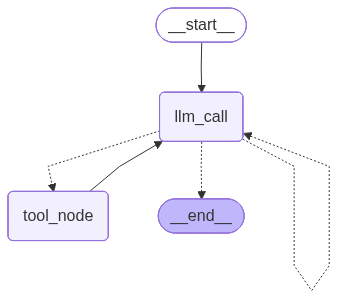

Response END
Returning END.
================================ Human Message =================================

Hypothetically, how much did I make if I earned [250k, 231k, 50k, 1M, 550k, 67k] in the last couple of years, paying 50k a month on stuff.
================================== Ai Message ==================================
Tool Calls:
  final_amount_calculator (5d36505f-6376-4b26-95b6-871d97a108b6)
 Call ID: 5d36505f-6376-4b26-95b6-871d97a108b6
  Args:
    annual_returns: [250000, 231000, 50000, 1000000, 550000, 67000]
    fixed_fee: 60000
    tax_rate: 0
================================= Tool Message =================================

2088000.0
================================== Ai Message ==================================

The total amount you made in the last couple of years is approximately $2,088,000.

To calculate this, I subtracted your monthly fixed fee of $50,000 from each year's income and then added them all together. 

$250,000 - $50,000 = $200,000
$231,000 - $50,000 

In [462]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage("Hypothetically, how much did I make if I earned [250k, 231k, 50k, 1M, 550k, 67k] in the last couple of years, paying 50k a month on stuff.")]
config: RunnableConfig = {"configurable": {"thread_id": "1"}}
messages = agent.invoke({"messages": messages}, config)
for m in messages["messages"]:
    m.pretty_print()

We see it takes the answer (which was wrong) from the  tool, and then corrects it (or attempts to, might be hallucinating). It could've gone on fetching llm calls and corresponding tool_calls, but decided to end the program. A few sho prompting scenario can be seen commented out below the tool_node.

In [463]:
# get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
list(agent.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hypothetically, how much did I make if I earned [250k, 231k, 50k, 1M, 550k, 67k] in the last couple of years, paying 50k a month on stuff.', additional_kwargs={}, response_metadata={}, id='46023c99-6eb3-4f3e-8d72-639a3898ce5b'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-10-13T04:51:17.564940012Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12756125664, 'load_duration': 104424504, 'prompt_eval_count': 293, 'prompt_eval_duration': 7366336794, 'eval_count': 57, 'eval_duration': 5283454058, 'model_name': 'llama3.2:latest'}, id='run--06246493-10c2-4779-ab67-5645c5fce3a9-0', tool_calls=[{'name': 'final_amount_calculator', 'args': {'annual_returns': [250000, 231000, 50000, 1000000, 550000, 67000], 'fixed_fee': '60000', 'tax_rate': '0'}, 'id': '5d36505f-6376-4b26-95b6-871d97a108b6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens'

We can see the whole history for the thread (messages + metadata).